In [274]:
import graphviz
import matplotlib.pyplot as plt

In [321]:
class Value:
    # children = ()  is an empty tuple
    def __init__(self, data, op = '', children = ()):
        self.data = data
        self.grad = 0
        #underscore means that variable is for internal use
        self._op = op
        # create set out of incoming children, so we will not duplicate
        # in case of same variable used twice in the arithmetic operation i.e (x * x)
        self._children = set(children)
        self._backward = lambda : None

    def __add__(self, other):
        other = other if isinstance(other, Value) else  Value(other)
        result = Value(self.data + other.data, '+', (self, other))
        def _backward():
            self.grad += result.grad * 1
            other.grad += result.grad * 1

        result._backward = _backward
        return result

    def __mul__(self, other):
        other = other if isinstance(other, Value) else  Value(other)
        result = Value(self.data * other.data, '*', (self, other))
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        result._backward = _backward
        return result
    
    def __pow__(self, other):
        result = Value(self.data ** other, f'**{other}', (self,))
        def _backward():
            self.grad += other * self.data ** (other - 1) * result.grad

        result._backward = _backward
        return result
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + -other
        
    def __repr__(self):
        return f'Value(data:{self.data}, grad:{self.grad:.3f})'
    
    def backward(self):
        visited = set()
        topological_order = []
        def visit(value):
            if value in visited:
                return
            visited.add(value)
            for child in value._children:
                visit(child)
            topological_order.append(value)
        visit(self)
        self.grad = 1
        for val in reversed(topological_order):
            val._backward()

In [276]:
x = Value(5)
y = Value(6)
z = Value(4)

xz = x + z # 11
xzy = xz + y # 15
print(xz)
#       xzy 
#        +  
#     /        \
#    +          y
#   / \
#  x   z






Value(data:9, grad:0.000)


In [305]:
# initially this function was supposed to print graph
# without graphviz, that is why BFS is used here
# but after adding graphviz visualization there is no 
# difference which traversal to use
# all this complexity to avoid duplciation and make the same variale represented correctly
# in different expressions
# TODO: separate concerns: 1) traverse graph to collect nodes and edges
#                          2) build graph visualization
def ValueBFS(value):
    assert isinstance(value, Value), "Incorrect argument"

    dag = graphviz.Digraph(comment = "Expression tree")
    # store in list (node, parent_id)
    list = [(value, -1)]
    visited_nodes_dict = {}
    visited_edges = set()
    node_id = 0
    while (len(list)):
        fixed_len = len(list)
        for _ in range(0, fixed_len):
            curr_value, parent_id = list.pop(0)
            
            # create a node with unique identifier
            curr_value_id = node_id; node_id += 1
            op_id = -1
            # create value node and store in the dictionary for the lookups
            if not (curr_value in visited_nodes_dict): 
                visited_nodes_dict[curr_value] = (curr_value_id, -1)
                dag.attr('node', shape = 'box')
                dag.node(str(curr_value_id), 
                         f'data={curr_value.data:.3f} | grad={curr_value.grad:.3f}')
            else:
                curr_value_id, op_id = visited_nodes_dict.get(curr_value)
            
            # create op node if possible and creates an edge between op and value
            if curr_value._op != '':
                if op_id == -1:
                    op_id = node_id; node_id += 1
                    visited_nodes_dict[curr_value] = (curr_value_id, op_id)

                dag.attr('node', shape = 'ellipse')
                dag.node(str(op_id), curr_value._op)
                if not (op_id, curr_value_id) in visited_edges:
                    dag.edge(str(op_id), str(curr_value_id))
                    visited_edges.add((op_id, curr_value_id))
            

            if parent_id != -1:
                dag.edge(str(curr_value_id), str(parent_id))
                visited_edges.add((curr_value_id, parent_id))

            new_parent_id = op_id if op_id != -1 else curr_value_id 
            for child in curr_value._children:
                if child in visited_nodes_dict:
                    v, op = visited_nodes_dict.get(child)
                    u = new_parent_id
                    if (v, u) in visited_edges:
                        continue
                list.append((child, new_parent_id))
            
    display(dag)




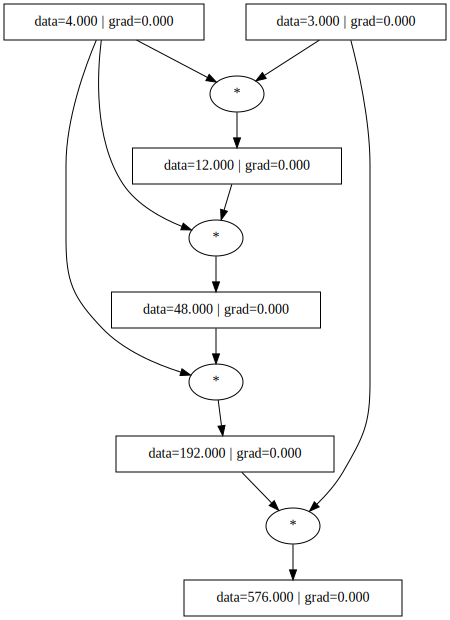

In [306]:
x = Value(3)
y = Value(4)
z = Value(5)

xy =  x * y # 12

#        48  192
zxyy = xy * y * y * x

zxyyy = zxyy * y
 
ValueBFS(zxyy)

# What is a neuron?
    Mathematical model of neuron is a function that takes as an input arbitrary X (vector of the input values) and multiples it by W (vector of the neuron weights) and adds bias (B). W and B are configurable parts of the neuron. To adjust or normalalize the output of the computed values, the result (X * W + B) goes through activation function. (i.e tanh)

    F(X) = X * W + B -> tanh(F(X)) (or any other activaiton function) 

    To understand the impact of configurable parameters, we need to look at derivatives with respect to each parameter. dWi/df

    Derivatives measure the senstivity to change of the function value with respect to a change in its argument. (f(x + h) - f(x)) / h

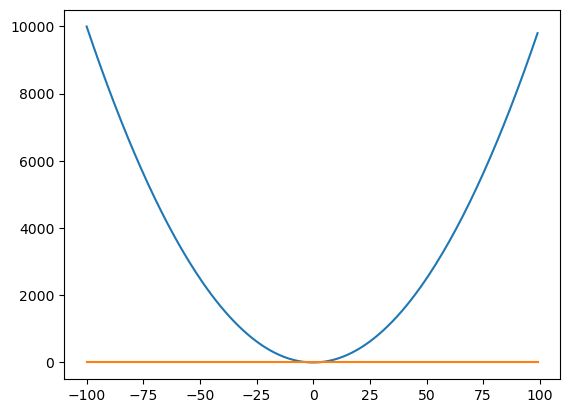

In [279]:
# calculating derrivatives of function
def f(x):
    return x ** 2

# derivative is a slope, instantaneous rate of change 
def derivative_f(x):
    h = 0.001
    return ( f(x + h) - f(x) ) / h


x = range(-100, 100)
y = []
for i in x:
    y.append(f(i))


# plot function
fig, ax = plt.subplots()
ax.plot(x, y)
# plot derivative in the fixed point
x_fixed = 0
slope = derivative_f(x_fixed)
y_der = []
def derivative_line(slope, x):
    return slope * x
for i in range(-100, 100):
    y_der.append(derivative_line(slope, i))
ax.plot(x, y_der)
plt.show()

# knowing derivative of the function we can manipulate the output of the function 
# if derivative with respect to input x is positive, then  by increasing x function will grow
# if derivative with respect to input x is negative, then by increasing x function will go down
# knowing the target value we can manipulate parameters to get the closet possible result



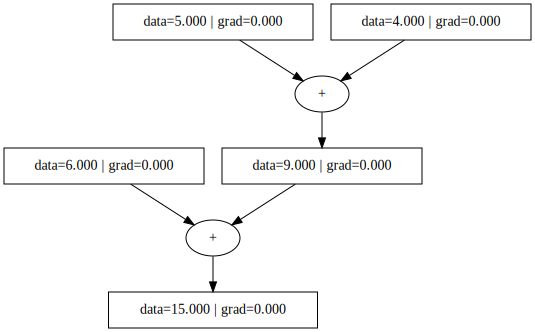

In [280]:
x = Value(5)
y = Value(6)
z = Value(4)

xz = x + z # 11
xzy = xz + y # 15
#       xzy 
#        +  
#     /        \
#    +          y
#   / \
#  x   z

ValueBFS(xzy)






In [281]:
x = 5
y = 6
z = 4
x_plus_z = x * z
g = x_plus_z + y

h = 0.001

# how y contributes to y contirbutes to g?
(x_plus_z + y + h - g )/ h
# that means if we slightly increase y, g will increase proportionally

# how x contributes to g?

# firstly, we need to calculate how x_plus_z contributes to g
# then calculate how x contributes to x_plus_z
# then multiply 2 results. Intuitively, with the first part we measure overall contribution by
# x_plus_z, then we scale it by single contribution of x

d_g_d_x_plus_z = (x_plus_z + h + y - g) / h

d_x_plus_z_d_x = (((x + h) * z) - x_plus_z) / h
d_x_plus_z_d_x * d_g_d_x_plus_z


4.000000000006224

In [282]:
# calculate gradient manually

# create a function
x = Value(5)
g = Value(10)
xg = x * g
y = Value(10)
u = Value(3)
yu = y * u
z = yu + xg

v = Value(2)
res = z * v


# manual backward pass
res.grad = 1

# 1
v.grad = z.data * res.grad
z.grad = v.data * res.grad

# 2
yu.grad = z.grad * 1
xg.grad = z.grad * 1

# 3
y.grad = u.data * yu.grad
u.grad = y.data * yu.grad

# 4
x.grad = xg.grad * g.data
g.grad = xg.grad * x.data

parameters = [x, g, xg, y, u, yu, z, v, res]


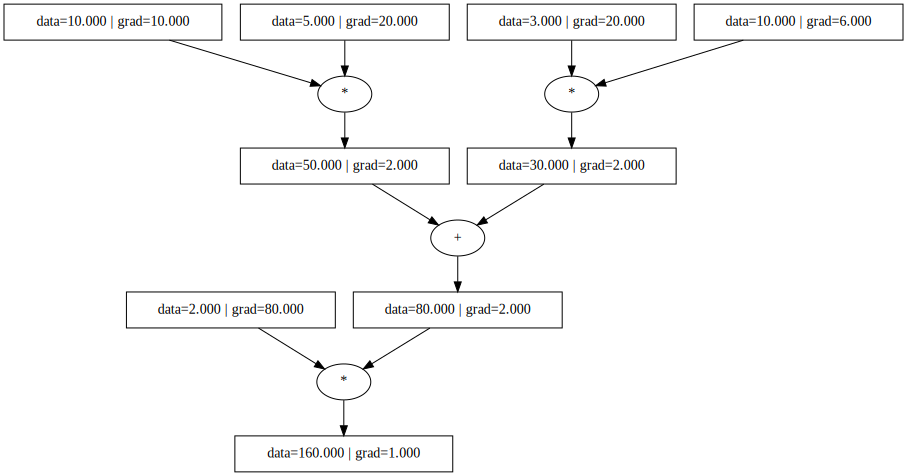

In [283]:
ValueBFS(res)


In [284]:
# or we can use _backward method called in the right order

# reset gradients
for parameter in parameters:
    parameter.grad = 0

# initial value
res.grad = 1

res._backward()
z._backward()
v._backward()
yu._backward()
xg._backward()
y._backward()
u._backward()
x._backward()
g._backward()


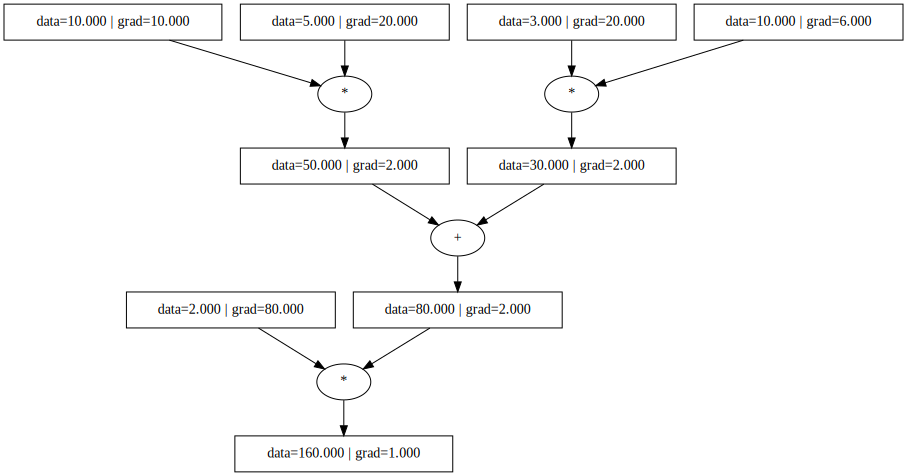

In [285]:

ValueBFS(res)

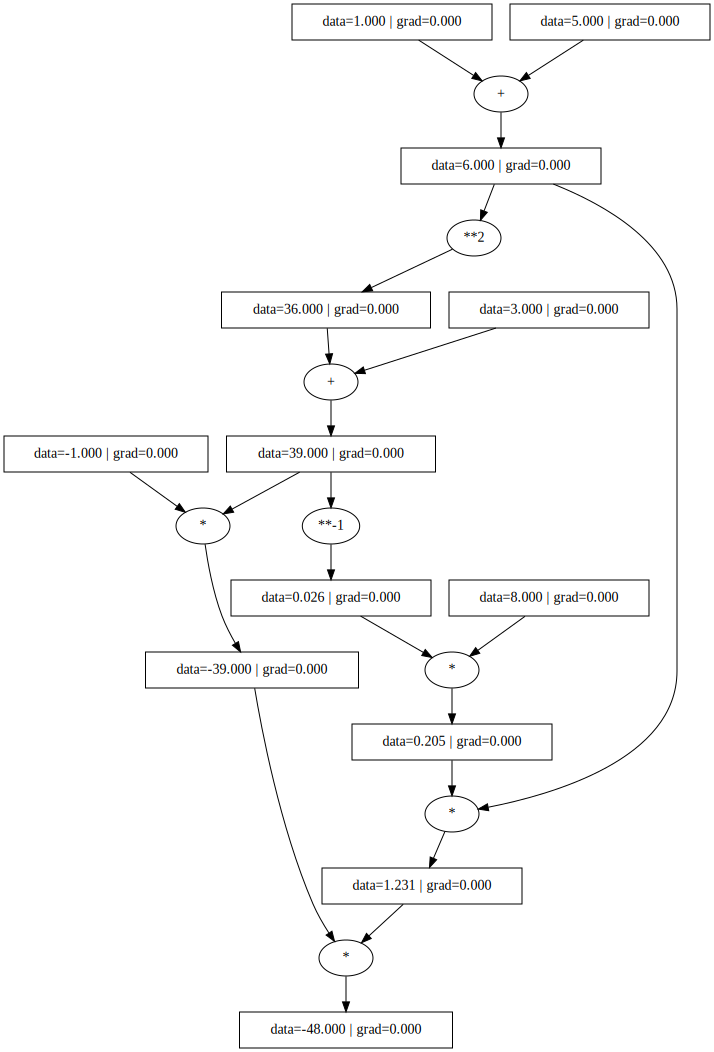

In [310]:
# Adding more arithmetic operations. Tests

x = Value(5) + Value(1)
y = x ** 2 + 3
zy = Value(8) / y
zxc = zy * x * -y
ValueBFS(zxc)

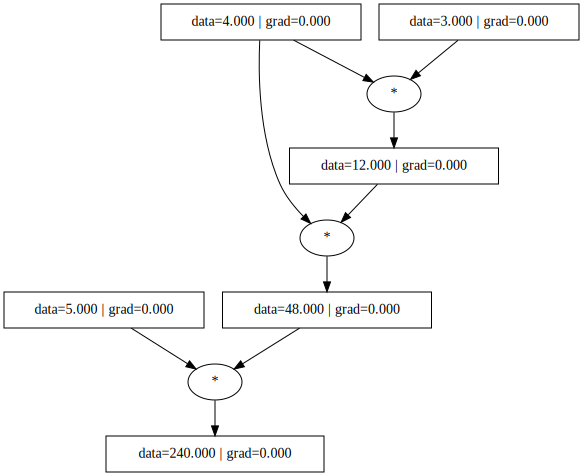

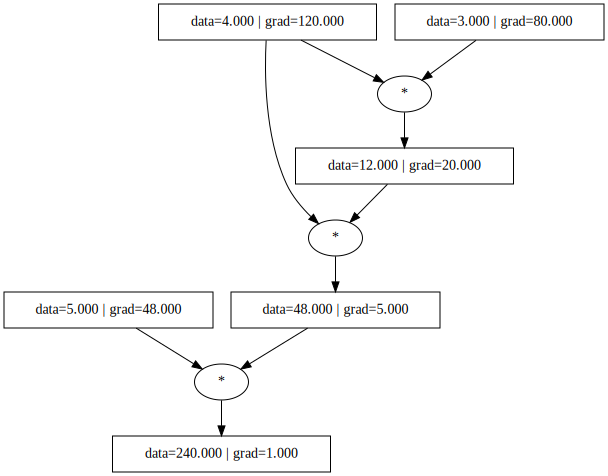

In [319]:
# the last thing left to do is to calculate backward pass automatically
# in order to do that we need to traverse our expression tree in topological order

# create a function
x = Value(3)
y = Value(4)
z = Value(5)

xy =  x * y

zxyy = xy * y * z
 
ValueBFS(zxyy)


def backward(value):
    assert isinstance(value, Value), "Incorrect argument"
    visited = set()
    topological_order = []
    def visit(value):
        if value in visited:
            return
        visited.add(value)
        for child in value._children:
            visit(child)
        topological_order.append(value)
    visit(value)
    value.grad = 1
    for val in reversed(topological_order):
        val._backward()

backward(zxyy)
ValueBFS(zxyy)

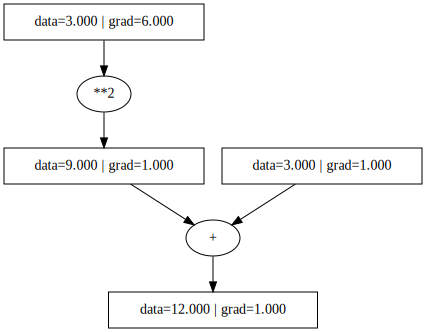

In [323]:
# test pow

x = Value(3) ** 2
y = x + 3

y.backward()
ValueBFS(y)

In [ ]:
# no we can create a neural net
# let's try to create MLP (Multilayer Perceptron) with exactly one layer :)